In [1]:
from Bio import Entrez

In [2]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

Let's let the nice folks at NCBI know who we are.

In [3]:
Entrez.email = "kt1451@student.uni-lj.si"

# How is SARS-CoV-2 spreading?

In the previous homework, we saw that we can infer how closely related different viruses are to one another by constructing pyhlogenetic trees. We know from biology and the theory of evolution that, if the organism are related to one another, they probably shared a common ancestor at some point in the past. The branching structure of the dendrograms hints at the possible time-frame of evolutionary distances between viruses.

Why not apply this same logic to a single, rapidly-mutating virus? SARS-CoV-2 is a RNA virus and mutates at a much faster rate than DNA-based organisms since it lacks many of the proof-reading and correction machinery that DNA-based organisms have. Could we trace the evolutionary path of this pesky virus from the time it was first reported to now by looking at different instances of SARS-CoV-2? Has it mutated in any major way? Is mutation related to geography? After all, we spread infect people close to us, so will we find that the virus went in a different evolutionary direction in different countries, continents? Let this be our motivation for the upcoming assignments.

![](https://images.theconversation.com/files/329931/original/file-20200423-47832-10m83yi.jpg?ixlib=rb-1.1.0&rect=17%2C8%2C726%2C370&q=45&auto=format&w=1000&fit=clip)

## Problem 1: UPGMA

In the previous homework we used hierarchical clustering algorithms implemented in scipy. This time, we will implement one of these clustering algorithms ourselves.

**TASK:** Implement the UPGMA algorithm you learned about in lectures for agglomerative hierarchical clustering in the `UPGMA` function in `helper_functions.py`. Your implementation should return a linkage matrix following the same format as that of `scipy.cluster.hierarchy.linkage`, so we can easily plot the dendrogram using existing scipy utilities. See the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) for the exact format. **[10 points]**

Hint: UPGMA is the same as hierarchical clustering using average linkage.

Once you have implemented the UPGMA algorithm, proceed to Problem 2.

In [4]:
from helper_functions import UPGMA

## Problem 2: Phylogenetic analysis

You are given 108 aligned sequences of SARS-CoV-2 collected at different time points around the world. Using the UPGMA algorithm you implemented earlier, plot a dendrogram of the sequences.

The aligned sequences are provided in *data/sars-cov-2.fa* in the fasta format. You can easily read these files using biopython's `SeqIO.parse`. Each record consists of a header indicating the accession id and the aligned sequence. You will need to use the standard NCBI fetching utilities we used in the previous homework to get metadata for each of the provided sequences.

Each NCBI record contains lots of interesting metadata. For the purposes of this homework, we really need three pieces of information. We need to know when the sequence was collected i.e. the collection date, which host the sequence was collected from e.g. humans, mice, ... (in case the host is not given, we can assume a human host), and where/what country the sequence was collected in. We can also convince ourselves that all the viruses are, in fact, SARS-CoV-2 viruses. All of this information can be found in an NCBI sequence record. Scan through the `record.features` field and search for one with `feature.type == "source"`. This object contains several qualifiers which contain all the required metadata.

**TASK:** We first need to calculate pairwise distances between each of our sequences. We'll do this in the same way as in Homework 2, using Hamming distance i.e. the number of mismatching symbols. This is sometimes also refered to as _genetic distance_. Implement the Jukes-Cantor correction in `helper_functions.py`. Apply the correction to the distances (see below for more information on Jukes-Cantor, you will learn more about this in future lectures). Since the sequences are already aligned, you do not have to perform the time-intensive alignment proceedure. Construct the dendrogram using your UPGMA implementation. Plot the phylogenetic tree using existing scipy utilities and save the resulting dendrogram into `problem2.png`. Label the tree branches using the accession id, the country or continent where the sequence was collected, and the collection date. Do the results make sense? Do you see any geographic grouping? What about grouping based on collection date. Save your answers into the `dendrogram_comments` variable.
**[10 points]** 

Hint: check out `scipy.cluster.hierarchy.dendrogram` to plot the dendrogram. Use `pandas.to_datetime` to parse and work with dates more easily.

**Jukes-Cantor correction**:
Estimating the genetic distance between two sequences is not as straightforward as it may initially seem. For instance, consider two nucleotides AC. Lets imagine this sequence undergoes the following mutations: AC -> CC -> TC -> GC -> TC. And imagine we observed onlt the first sequence i.e. AC and the last sequence TC. What is the distance between these two sequences? Well, AC and TC only differ in the first nucleotide, so their genetic distance must be 1. But, we know from the above transitions that there have actually been four mutations. So our naive estimation of genetic distance systematically underestimates the distance between sequences. One way to correct for this is by using the Jukes-Cantor correction. You can read more about it in the book "Introduction to Computational Genomics" by Cristianini and Hahn in section 5.4.1. But in essence, your job is to correct the distances in the following way. 1 - calculate the Hamming/genetic distance between sequences. 2 - convert these distances to proportions of the sequence length i.e. divide the distances by the lengths of the sequences being compared (in the above example, we would have 1 mutation and sequence length 2, therefore the proportianal distance would be 0.5). 3 - Calculate the correction using d_corrected = -3/4 log (1 - 4/3 d_proportions).

In [5]:
from Bio import SeqIO
c=0
s=SeqIO.parse("data/sars-cov-2.fa", "fasta")
dict_fasta={}
list_fasta=[]
for record in s:
    #print(record.id)
    dict_fasta[record.id]=record.seq
    list_fasta.append([record.id,record.seq])  

In [6]:
import pickle
from os import path
from typing import Tuple, Generator, List

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord


def load(organism_id: str) -> SeqRecord:
    """Load the NCBI record, use cached files if possible."""
    if not path.exists(path.join("data", f"{organism_id}.pkl.gz")):
        with Entrez.efetch(db="nucleotide", rettype="gb", id=organism_id) as handle:
            record = SeqIO.read(handle, "gb")
            with open(path.join("data", f"{organism_id}.pkl.gz"), "wb") as f:
                pickle.dump(record, f)
    else:
        with open(path.join("data", f"{organism_id}.pkl.gz"), "rb") as f:
            record = pickle.load(f)

    return record


In [7]:

#print(acc_vals)
list_fasta_ncbi=[]
dict_ncbi_fasta={}
print(len(list_fasta))
d=0
for id_sec_fasta in list_fasta:
    record=load(id_sec_fasta[0])
    record.features
    temp_dict={}
    temp_dict["sequence"]=id_sec_fasta[1]
    #c=0
    for i in record.features:
        #print("new i")
        if(i.type == "source"):
            #print(i)
            temp_dict["host"]="Homo sapiens" #default than if exist setsthe other value
            
                
            try:
                #print(i.qualifiers["host"],id_sec_fasta[0])
                temp_dict["host"]=i.qualifiers["host"]
            except:
                print(id_sec_fasta[0],"no host",temp_dict["host"])    
            try:
                #print(i.qualifiers["collection_date"],id_sec_fasta[0])
                temp_dict["collection_date"]=i.qualifiers["collection_date"]
            except:
                print(id_sec_fasta[0],"no dateXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")    
            try:
               #print(i.qualifiers["country"],id_sec_fasta[0])
                temp_dict["country"]=i.qualifiers["country"]
            except:
                print(id_sec_fasta[0],"no countryxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
            #isolate
            #try:
                #print(i.qualifiers["isolate"],id_sec_fasta[0])
                #temp_dict["isolate"]=i.qualifiers["isolate"]
            #except:
                #print(id_sec_fasta[0],"no isolatexxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
            d+=1
            dict_ncbi_fasta[id_sec_fasta[0]]=temp_dict
            break
#print(d)
print(dict_ncbi_fasta)


108
MT476384.1 no host Homo sapiens
{'MN908947.3': {'sequence': Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'), 'host': ['Homo sapiens'], 'collection_date': ['Dec-2019'], 'country': ['China']}, 'NC_045512.2': {'sequence': Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'), 'host': ['Homo sapiens'], 'collection_date': ['Dec-2019'], 'country': ['China']}, 'MT049951.1': {'sequence': Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'), 'host': ['Homo sapiens'], 'collection_date': ['17-Jan-2020'], 'country': ['China: Yunnan']}, 'MT291826.1': {'sequence': Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'), 'host': ['Homo sapiens'], 'collection_date': ['2019-12-30'], 'country': ['China: Wuhan']}, 'MT291827.1': {'sequence': Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'), 'host': ['Homo sapiens'], 'collection_date': ['2019-12-30'], 'country': ['China: Wuhan']}, 'MT291828.1': {'sequence': Seq('GTCACTCGGCT

In [8]:
#print(dict_ncbi_fasta["MT159721.2"]["sequence"])
def hamm_dist(seq1,seq2):
    c=0
    for i in range(min(len(seq1),len(seq2))):
        if seq1[i]!=seq2[i]:
            c=c+1
    return c
        

In [9]:
hamm_dist(list_fasta[0][1],list_fasta[1][1])
for i in range(len(list_fasta[0][1])):
    if(list_fasta[0][1][i]!=list_fasta[1][1][i]):
        print("bad")

In [10]:
hamm_dist_list=[]
for i in range(107):
    for j in range(i+1,108):
        hamm_dist_list.append([list_fasta[i][0],list_fasta[j][0],hamm_dist(list_fasta[i][1],list_fasta[j][1])])

In [11]:
print(hamm_dist_list)

[['MN908947.3', 'NC_045512.2', 0], ['MN908947.3', 'MT049951.1', 4], ['MN908947.3', 'MT291826.1', 3], ['MN908947.3', 'MT291827.1', 0], ['MN908947.3', 'MT291828.1', 1], ['MN908947.3', 'MT291829.1', 0], ['MN908947.3', 'MT034054.1', 1], ['MN908947.3', 'MT039890.1', 9], ['MN908947.3', 'MT066175.1', 2], ['MN908947.3', 'MT270104.1', 4], ['MN908947.3', 'MT270105.1', 4], ['MN908947.3', 'MW161259.1', 3], ['MN908947.3', 'MT952134.1', 3], ['MN908947.3', 'MN985325.1', 3], ['MN908947.3', 'LC542976.1', 4], ['MN908947.3', 'LC553269.1', 1], ['MN908947.3', 'MT270106.1', 4], ['MN908947.3', 'MT447154.1', 2], ['MN908947.3', 'MT755891.1', 11], ['MN908947.3', 'MT159710.2', 1], ['MN908947.3', 'MT184908.2', 4], ['MN908947.3', 'MT159721.2', 1], ['MN908947.3', 'MT476384.1', 5], ['MN908947.3', 'MT510728.1', 5], ['MN908947.3', 'MT358638.1', 6], ['MN908947.3', 'MT358640.1', 10], ['MN908947.3', 'MT483867.1', 8], ['MN908947.3', 'MT499198.1', 5], ['MN908947.3', 'MT738101.1', 12], ['MN908947.3', 'MT517433.1', 10], ['MN

In [12]:
import numpy as np
hamm_dist_matrix=np.zeros((108,108), dtype=float)
for i in range(107):
    for j in range(i+1,108):
        k=hamm_dist(list_fasta[i][1],list_fasta[j][1])
        hamm_dist_matrix[i][j]=k
        hamm_dist_matrix[j][i]=k

In [13]:
#for i in range(108):
    #print(len(list_fasta[i][1]))
    

In [14]:
#hamm_dist_matrix

In [15]:
hamm_dist_matrix_avg=np.zeros((108,108), dtype=float)
for i in range(107):
    for j in range(i+1,108):
        hamm_dist_matrix_avg[i][j]=float(hamm_dist_matrix[i][j]/float(29745))
        hamm_dist_matrix_avg[j][i]=float(hamm_dist_matrix[j][i]/float(29745))
        

In [16]:
#hamm_dist_matrix_avg*29745

In [17]:
from helper_functions import jukes_cantor
hamm_dist_matrix_avg_jukes_cantor=np.zeros((108,108), dtype=float)
for i in range(107):
    for j in range(i+1,108):
        
        hamm_dist_matrix_avg_jukes_cantor[i][j]=jukes_cantor(hamm_dist_matrix_avg[i][j])
        hamm_dist_matrix_avg_jukes_cantor[j][i]=jukes_cantor(hamm_dist_matrix_avg[j][i])

In [18]:
for i in range(len(hamm_dist_matrix_avg_jukes_cantor)):
    for j in range(len(hamm_dist_matrix_avg_jukes_cantor)):
        if hamm_dist_matrix_avg_jukes_cantor[i][j]<0:
            print(hamm_dist_matrix_avg_jukes_cantor[i][j])

In [19]:
#hamm_dist_matrix_avg_jukes_cantor

In [20]:
hamm_dist_matrix_avg_UPGMA=UPGMA(hamm_dist_matrix_avg_jukes_cantor)

In [21]:
len(hamm_dist_matrix_avg_UPGMA)

107

In [22]:
#hamm_dist_matrix_avg_UPGMA

In [23]:
#dict_ncbi_fasta

In [24]:
#i,i["country"]+i["collection_date"]
labels_dendro=[]
for ii in dict_ncbi_fasta:
    s=ii+" "+dict_ncbi_fasta[ii]["country"][0]+" "+dict_ncbi_fasta[ii]["collection_date"][0]
    labels_dendro.append(s)
labels_dendro

['MN908947.3 China Dec-2019',
 'NC_045512.2 China Dec-2019',
 'MT049951.1 China: Yunnan 17-Jan-2020',
 'MT291826.1 China: Wuhan 2019-12-30',
 'MT291827.1 China: Wuhan 2019-12-30',
 'MT291828.1 China: Wuhan 2019-12-30',
 'MT291829.1 China: Wuhan 2019-12-30',
 'MT034054.1 China: Beijing 2020-01-03',
 'MT039890.1 South Korea Jan-2020',
 'MT066175.1 Taiwan 31-Jan-2020',
 'MT270104.1 Germany: Bavaria 2020-01',
 'MT270105.1 Germany: Bavaria 2020-01',
 'MW161259.1 USA 2020-01-19',
 'MT952134.1 USA 2020-01-19',
 'MN985325.1 USA 19-Jan-2020',
 'LC542976.1 Japan 2020-02',
 'LC553269.1 Japan 2020-02',
 'MT270106.1 Germany: Bavaria 2020-02-01',
 'MT447154.1 Thailand 2020-02-01',
 'MT755891.1 Saudi Arabia 2020-02-17',
 'MT159710.2 USA 2020-02-17',
 'MT184908.2 USA 2020-02-21',
 'MT159721.2 USA 2020-02-21',
 'MT476384.1 USA: FL 2020-02-21',
 'MT510728.1 China 2020-02-13',
 'MT358638.1 Germany 2020-02',
 'MT358640.1 Germany 2020-02',
 'MT483867.1 Italy 2020-03-04',
 'MT499198.1 USA: CA 2020-03-19',
 

<Figure size 432x288 with 0 Axes>

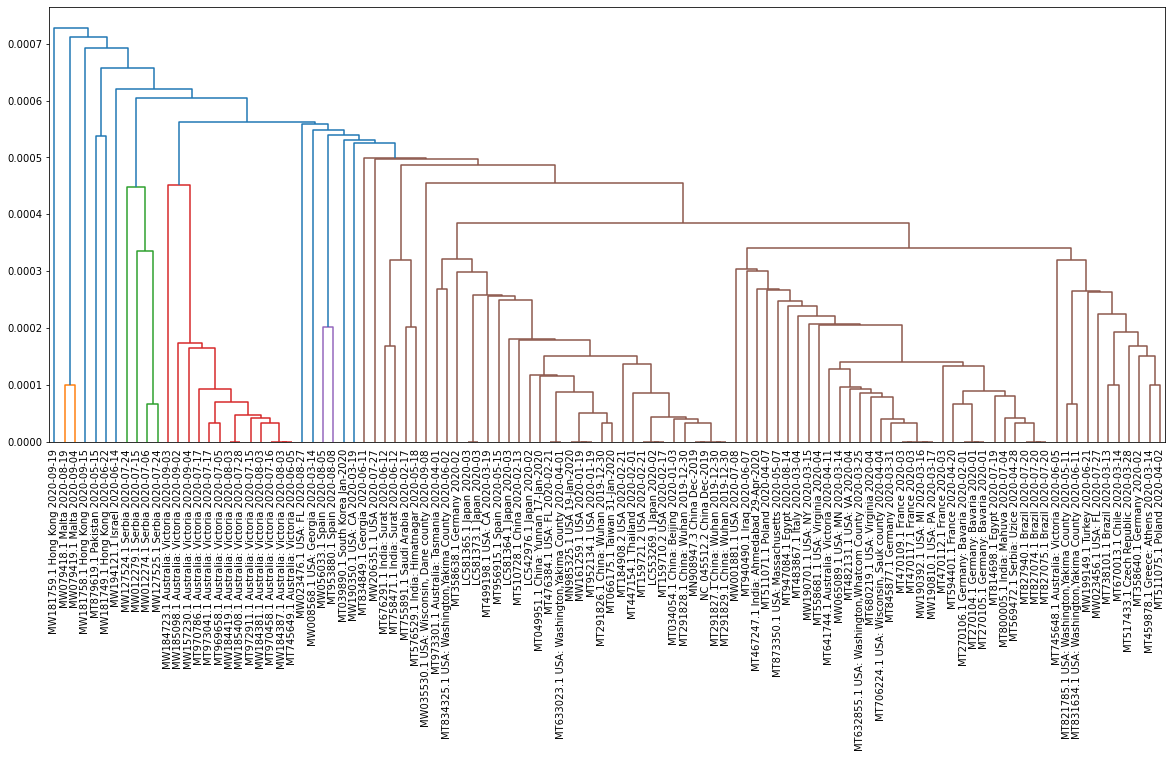

<Figure size 432x288 with 0 Axes>

In [25]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
dn = hierarchy.dendrogram(hamm_dist_matrix_avg_UPGMA,labels=labels_dendro,leaf_font_size=10, leaf_rotation=90)
plt.savefig('problem2.png', format='png', bbox_inches='tight')
plt.figure()

In [26]:
dendrogram_comments = """
In smaller or like more isolated countries it can be seen that mutations are more likely to occure from similar source, ex. Serbia and Australia. It doesn't mean that all viruses in Serbia mutated there but their source is like from certain areas in other countries where it migrated from serbia and continue to migrate there but is not found in that country, or the obvious which is must likely they mutated in the country.
Also the thing that in smaller or more isolated countries including Brazil since virus mutations are similar it is possibly that they mutated there, so the virus mutates.
Countries that are bigger and not so isolated like Germany for example the mutation of viruses are more similar if they are found in closer time period if the time is longer they are different which means they are kind of more vulnerable to varieties coming from the other countries.
The fact that the virus has more mutations in Wuhan in smaller time interval means that virus most likely originated there so when it spread from that same source it was more prone to mutating since the virus is first time in human host it;s vulnerable and needs a stable version to survive there.
About Wuhan we can say think that more tests are done there on the virus mutations so more mutations are discovered there.
But on usual where something orginates has most genetic variance.
"""

## Problem 3a: Rate of mutation

**TASK:** Find the virus with the earliest collection date -- we'll use this as our starting point for any subsequent mutations. Calculate the genetic distance (with the JC correction) from this starting sequence to all the other sequences and plot the dependence of genetic distance to the time elapsed from this starting point. Put genetic distance on the y-axis, and time in days (the number of days since the starting point) on your x-axis. The starting point should be located at the origin. Fit a linear regression line to the points and overlay the regression line onto your plot. Save the resulting figure into `problem3a.png`. Report the slope of the line and save it into the `sars_cov_2_coeff` variable. Write down any comments into the `sars_cov_2_mutation_comments` variable.
**[5 points]** 

Hint: check out `np.polyfit` to fit the linear regression curve.

In [27]:
import pandas as pd
x=0
for ii in dict_ncbi_fasta:
    
    y=0
    print(dict_ncbi_fasta[ii]["collection_date"][0])
    print(type(dict_ncbi_fasta[ii]["collection_date"][0]))
    s=pd.to_datetime(dict_ncbi_fasta[ii]["collection_date"][0])
    
    if x!=0: y=s
    if(x==0): x=s 
    print("s=",s)
    print(type(s))


Dec-2019
<class 'str'>
s= 2019-12-01 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Dec-2019
<class 'str'>
s= 2019-12-01 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
17-Jan-2020
<class 'str'>
s= 2020-01-17 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2019-12-30
<class 'str'>
s= 2019-12-30 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2019-12-30
<class 'str'>
s= 2019-12-30 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2019-12-30
<class 'str'>
s= 2019-12-30 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2019-12-30
<class 'str'>
s= 2019-12-30 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2020-01-03
<class 'str'>
s= 2020-01-03 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Jan-2020
<class 'str'>
s= 2020-01-01 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
31-Jan-2020
<class 'str'>
s= 2020-01-31 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2020-01
<class

In [28]:
import datetime
from datetime import datetime
print(y,x)
print(min(y,x))
#x=pd.to_datetime(x).dt.date
#x = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
x1 = x.date()
#y = datetime.strptime(y, '%Y-%m-%d %H:%M:%S')
y1 = y.date()
#y=pd.to_datetime(y)
print(y1,x1)
print(min(y1,x1))
z=(y-x)
z=str(z).replace("00:00:00","")
print(z)

2020-03-19 00:00:00 2019-12-01 00:00:00
2019-12-01 00:00:00
2020-03-19 2019-12-01
2019-12-01
109 days 


In [29]:
#dict_ncbi_fasta["MN908947.3"]["collection_date"]

In [30]:
#["MN908947.3"]
dict_ncbi_fasta_date={}
list_ncbi_fasta_date=[]
for ii in dict_ncbi_fasta: 
    dict_ncbi_fasta_date[ii]={}
    dict_ncbi_fasta_date[ii]["collection_date"]=pd.to_datetime(dict_ncbi_fasta[ii]["collection_date"][0])
    dict_ncbi_fasta_date[ii]["sequence"]=dict_ncbi_fasta[ii]["sequence"]
    dict_ncbi_fasta_date[ii]["country"]=dict_ncbi_fasta[ii]["country"]
    list_ncbi_fasta_date.append([ii,pd.to_datetime(dict_ncbi_fasta[ii]["collection_date"][0]),dict_ncbi_fasta[ii]["sequence"],dict_ncbi_fasta[ii]["country"]])

In [31]:
str(list_ncbi_fasta_date[3][1]-list_ncbi_fasta_date[1][1]).replace(" 00:00:00","")

'29 days'

In [32]:
list_ncbi_fasta_date.sort(key = lambda x: x[1]) 

In [33]:
list_ncbi_fasta_date

[['MN908947.3',
  Timestamp('2019-12-01 00:00:00'),
  Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'),
  ['China']],
 ['NC_045512.2',
  Timestamp('2019-12-01 00:00:00'),
  Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'),
  ['China']],
 ['MT291826.1',
  Timestamp('2019-12-30 00:00:00'),
  Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'),
  ['China: Wuhan']],
 ['MT291827.1',
  Timestamp('2019-12-30 00:00:00'),
  Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'),
  ['China: Wuhan']],
 ['MT291828.1',
  Timestamp('2019-12-30 00:00:00'),
  Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'),
  ['China: Wuhan']],
 ['MT291829.1',
  Timestamp('2019-12-30 00:00:00'),
  Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'),
  ['China: Wuhan']],
 ['MT039890.1',
  Timestamp('2020-01-01 00:00:00'),
  Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'),
  ['South Korea']],
 ['MT2

In [34]:
len(list_ncbi_fasta_date[0][2])

29745

In [35]:
print(len(list_ncbi_fasta_date))

108


In [36]:
list_ncbi_fasta_date.sort(key = lambda x: x[1]) 
list_ncbi_fasta_date_hd0=[]
ref_virus=list_ncbi_fasta_date[0]
for i in range(108):
    k=hamm_dist(list_ncbi_fasta_date[0][2],list_ncbi_fasta_date[i][2])
    #print(k)
    s=list_ncbi_fasta_date[i][1]-list_ncbi_fasta_date[0][1]
    s=str(s).replace(" 00:00:00","")
    #print(s)
    ss=[int(i) for i in s.split() if i.isdigit()]
    print(ss[0])
    list_ncbi_fasta_date_hd0.append([list_ncbi_fasta_date[i][0],s,k,ss])
print("ssssss",len(list_ncbi_fasta_date_hd0))

0
0
29
29
29
29
31
31
31
33
47
49
49
49
61
62
62
62
62
62
62
74
78
78
82
82
82
91
91
91
91
91
91
94
103
104
104
104
104
105
106
107
109
109
115
118
121
122
122
122
122
122
123
125
128
132
141
149
150
158
162
166
166
169
184
187
187
189
193
193
194
194
196
203
204
216
217
218
220
227
227
228
229
229
231
232
232
232
236
236
239
239
240
246
246
246
248
251
257
262
270
276
277
278
278
282
289
293
ssssss 108


In [37]:
#list_ncbi_fasta_date_hd0[2]/29745
list_3_fin=[]
for i in range(108):
    list_3_fin.append([list_ncbi_fasta_date_hd0[i][0],list_ncbi_fasta_date_hd0[i][1],jukes_cantor(float(list_ncbi_fasta_date_hd0[i][2]/29745)),list_ncbi_fasta_date_hd0[i][3][0]])
list_3_fin

[['MN908947.3', '0 days', -0.0, 0],
 ['NC_045512.2', '0 days', -0.0, 0],
 ['MT291826.1', '29 days', 0.00010086406900858817, 29],
 ['MT291827.1', '29 days', -0.0, 29],
 ['MT291828.1', '29 days', 3.361984916461045e-05, 29],
 ['MT291829.1', '29 days', -0.0, 29],
 ['MT039890.1', '31 days', 0.00030263291039092297, 31],
 ['MT270104.1', '31 days', 0.0001344884399582344, 31],
 ['MT270105.1', '31 days', 0.0001344884399582344, 31],
 ['MT034054.1', '33 days', 3.361984916461045e-05, 33],
 ['MT049951.1', '47 days', 0.0001344884399582344, 47],
 ['MW161259.1', '49 days', 0.00010086406900858817, 49],
 ['MT952134.1', '49 days', 0.00010086406900858817, 49],
 ['MN985325.1', '49 days', 0.00010086406900858817, 49],
 ['MT066175.1', '61 days', 6.724120545570752e-05, 61],
 ['LC542976.1', '62 days', 0.0001344884399582344, 62],
 ['LC553269.1', '62 days', 3.361984916461045e-05, 62],
 ['MT270106.1', '62 days', 0.0001344884399582344, 62],
 ['MT447154.1', '62 days', 6.724120545570752e-05, 62],
 ['MT358638.1', '62 d

In [38]:
df_3_fin=pd.DataFrame(list_3_fin)

In [39]:
df_3_fin[2]

0     -0.000000
1     -0.000000
2      0.000101
3     -0.000000
4      0.000034
         ...   
103    0.000639
104    0.000572
105    0.000404
106    0.000639
107    0.000639
Name: 2, Length: 108, dtype: float64

In [40]:
import scipy
from scipy.interpolate import *

pl=np.polyfit(df_3_fin[3],df_3_fin[2],1)
print(pl)
#1.8105030746624837e-06


[1.81050307e-06 3.93237785e-05]


In [41]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df_3_fin[3],df_3_fin[2])

In [42]:
print(slope)

1.8105030746624842e-06


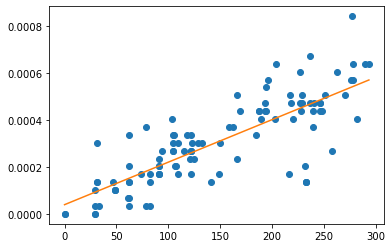

In [43]:
#this is just a trial
plt.plot(df_3_fin[3],df_3_fin[2],'o')
plt.plot(df_3_fin[3],np.polyval(pl,df_3_fin[3]),'-')

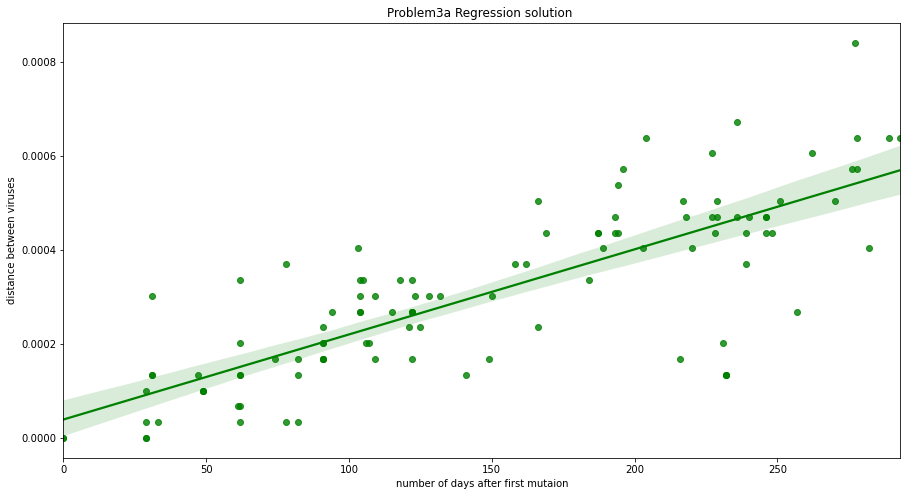

In [44]:
import seaborn as sns
import numpy as np;
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
#x=np.array(list_3_fin[2])
ax = sns.regplot(x=df_3_fin[3], y=df_3_fin[2], color="g")
ax.set(xlabel='number of days after first mutaion', ylabel='distance between viruses')
plt.title('Problem3a Regression solution ')
plt.savefig('problem3a.png')

0.0 3.9323778534819846e-05
100 100
1.8105030746624827e-06
1.8105030746624829e-06


1.8105030746624837e-06

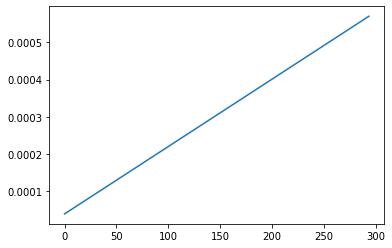

In [45]:
c=ax.get_lines()[0].get_xdata()
ct=ax.get_lines()[0].get_ydata()
print(c[0],ct[0])
plt.plot(c,ct)
print(len(c),len(ct))
print(float(ct[2]-ct[1])/float(c[2]-c[1]))
print(float(ct[3]-ct[1])/float(c[3]-c[1]))
(float(ct[99]-ct[0])/float(c[99]-c[0]))

In [46]:
sars_cov_2_coeff = 1.8105030746624837e-06
sars_cov_2_mutation_comments = """
about the coeficient why is it so "low" compared to 1:1 ratio: mutaions as we calculated them happen very 'little' per each day so the coeficient is completly ok I guess I do not have scale to compare if its low or high
there are 2 factors for mutaion numbers: mutations and tests for mutations
the mutations in the graph happen pretty linearly as the regression line is and the data we posses of them
however in real life i think mutations should have exponential functions
but as i said in the given time period with the given tests and measures the graph seems ok 
"""

## Problem 3b: Mutation rate in other viruses

How fast is this rate of mutation in SARS-CoV-2? Is it mutating quickly? Or slowly? Or at an average rate? We really can't tell without a frame of reference. In this exercise, we will look at two more viruses, Ebola and HIV, and determine their rate of mutation. These will help us get some kind of reference for the speed at which viruses mutate.

**TASK:** Find the aligned sequences for Ebola and HIV viruses in the accompanying fasta files. You will again need to download the sequence metadata from NCBI. As in 3a, estimate the slope of the regression line for each of the viruses. Report the slopes of both lines and save them to their corresponding variables, `ebola_coeff` and `hiv_coeff`. Given this reference frame, how fast is SARS-CoV-2 mutating? Examine the ratios of the slopes. Write your observations into the `mutation_comments` variable.
**[5 points]** 

**A note on HIV.** HIV has been around for a long time, and when it first appeared, high-throughput sequencing technologies were still in their infancy. Therefore sequences are much harder to come by. You will notice that whichever staring point you choose, the sequences are all further from each other than in Ebola and SARS-CoV-2. On your plots, this will become apparent as the starting point will be located at the origin, and the remaining sequences will all be shifted higher up the y-axis. However, the rate of mutation is fairly constant, so you can still estimate the rate of mutation by looking at the regression line. This is because the viruses will be much more different from one another. However, we can still look at the differences over time to estimate the rate of mutation. Just be sure to exclude the starting point (origin) from the linear regression fit, as this will skew the regression line.

In [47]:
from Bio import SeqIO
c=0
ebola=SeqIO.parse("data/ebola.fa", "fasta")

for record in SeqIO.parse("data/ebola.fa", "fasta"):
    print(record.id)
    #if(record.id==("MN908947.3")):
        #print(record.seq)
hiv=SeqIO.parse("data/hiv.fa", "fasta")

#for record in SeqIO.parse("data/hiv.fa", "fasta"):
    #print(record.id)
    #if(record.id==("MN908947.3")):
        #print(record.seq)
  

KM034553.1
KM034554.1
KM034557.1
KM034558.1
KM034559.1
KM034560.1
KM034561.1
KM034562.1
KP184503.1
KP120616.1
KY558985.1
KY558987.1
KP260801.1
KY558984.1
KT357851.1
KT357813.1
KT357853.1
MF102255.1
MF599508.1
MF599509.1
MF599510.1
MF599511.1
KM233106.1
KM233068.1
KM233091.1
KM233115.1
KM233037.1
KP260800.1
KP260802.1
KP728283.1


In [48]:
ebola=SeqIO.parse("data/ebola.fa", "fasta")
dict_fasta_ebola={}
list_fasta_ebola=[]
for record in ebola:
    #print(record.id)
    dict_fasta_ebola[record.id]=record.seq
    list_fasta_ebola.append([record.id,record.seq])  

In [49]:

#print(acc_vals)
list_fasta_ncbi_ebola=[]
dict_ncbi_fasta_ebola={}
print(len(list_fasta))
d=0
for id_sec_fasta in list_fasta_ebola:
    record=load(id_sec_fasta[0])
    record.features
    temp_dict={}
    temp_dict["sequence"]=id_sec_fasta[1]
    #c=0
    for i in record.features:
        #print("new i")
        if(i.type == "source"):
            #print(i)
            temp_dict["host"]="Homo sapiens" #default than if exist setsthe other value
            
                
            try:
                #print(i.qualifiers["host"],id_sec_fasta[0])
                temp_dict["host"]=i.qualifiers["host"]
            except:
                print(id_sec_fasta[0],"no host",temp_dict["host"])    
            try:
                #print(i.qualifiers["collection_date"],id_sec_fasta[0])
                temp_dict["collection_date"]=i.qualifiers["collection_date"]
            except:
                print(id_sec_fasta[0],"no dateXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")    
            try:
               #print(i.qualifiers["country"],id_sec_fasta[0])
                temp_dict["country"]=i.qualifiers["country"]
            except:
                print(id_sec_fasta[0],"no countryxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
            #isolate
            #try:
                #print(i.qualifiers["isolate"],id_sec_fasta[0])
                #temp_dict["isolate"]=i.qualifiers["isolate"]
            #except:
                #print(id_sec_fasta[0],"no isolatexxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
            d+=1
            dict_ncbi_fasta_ebola[id_sec_fasta[0]]=temp_dict
            break
#print(d)
print(dict_ncbi_fasta_ebola)


108
{'KM034553.1': {'sequence': Seq('TTAAATTGAAATTGTTACTGTAATCATACCTGGTTTGTTTCAGAGCCATATCAC...ATC'), 'host': ['Homo sapiens'], 'collection_date': ['27-May-2014'], 'country': ['Sierra Leone']}, 'KM034554.1': {'sequence': Seq('TTAAATTGAAATTGTTACTGTAATCATACCTGGTTTGTTTCAGAGCCATATCAC...ATC'), 'host': ['Homo sapiens'], 'collection_date': ['27-May-2014'], 'country': ['Sierra Leone']}, 'KM034557.1': {'sequence': Seq('TTAAATTGAAATTGTTACTGTAATCATACCTGGTTTGTTTCAGAGCCATATCAC...ATC'), 'host': ['Homo sapiens'], 'collection_date': ['27-May-2014'], 'country': ['Sierra Leone']}, 'KM034558.1': {'sequence': Seq('TTAAATTGAAATTGTTACTGTAATCATACCTGGTTTGTTTCAGAGCCATATCAC...ATC'), 'host': ['Homo sapiens'], 'collection_date': ['28-May-2014'], 'country': ['Sierra Leone']}, 'KM034559.1': {'sequence': Seq('TTAAATTGAAATTGTTACTGTAATCATACCTGGTTTGTTTCAGAGCCATATCAC...ATC'), 'host': ['Homo sapiens'], 'collection_date': ['28-May-2014'], 'country': ['Sierra Leone']}, 'KM034560.1': {'sequence': Seq('TTAAATTGAAATTGTTACTGTAA

In [50]:
#["MN908947.3"]
dict_ncbi_fasta_date_ebola={}
list_ncbi_fasta_date_ebola=[]
for ii in dict_ncbi_fasta_ebola: 
    dict_ncbi_fasta_date_ebola[ii]={}
    dict_ncbi_fasta_date_ebola[ii]["collection_date"]=pd.to_datetime(dict_ncbi_fasta_ebola[ii]["collection_date"][0])
    dict_ncbi_fasta_date_ebola[ii]["sequence"]=dict_ncbi_fasta_ebola[ii]["sequence"]
    dict_ncbi_fasta_date_ebola[ii]["country"]=dict_ncbi_fasta_ebola[ii]["country"]
    list_ncbi_fasta_date_ebola.append([ii,pd.to_datetime(dict_ncbi_fasta_ebola[ii]["collection_date"][0]),dict_ncbi_fasta_ebola[ii]["sequence"],dict_ncbi_fasta_ebola[ii]["country"]])

In [51]:
list_ncbi_fasta_date_ebola.sort(key = lambda x: x[1]) 
list_ncbi_fasta_date_hd0_ebola=[]
ref_virus=list_ncbi_fasta_date_ebola[0]
for i in range(len(list_ncbi_fasta_date_ebola)):
    k=hamm_dist(list_ncbi_fasta_date_ebola[0][2],list_ncbi_fasta_date_ebola[i][2])
    #print(k)
    s=list_ncbi_fasta_date_ebola[i][1]-list_ncbi_fasta_date_ebola[0][1]
    s=str(s).replace(" 00:00:00","")
    #print(s)
    ss=[int(i) for i in s.split() if i.isdigit()]
    print(ss[0])
    list_ncbi_fasta_date_hd0_ebola.append([list_ncbi_fasta_date_ebola[i][0],s,k,ss])
print("ssssss",len(list_ncbi_fasta_date_hd0_ebola))

0
0
0
1
1
1
1
1
7
19
20
21
22
90
90
97
97
169
169
178
178
188
255
268
268
309
314
319
329
329
ssssss 30


In [52]:
#for i in range(len(list_ncbi_fasta_date_hd0_ebola)):
    #print(len(list_ncbi_fasta_date_ebola[i][2]))

In [53]:
#list_ncbi_fasta_date_hd0[2]/29745
list_3_fin_ebola=[]
for i in range(len(list_ncbi_fasta_date_hd0_ebola)):
    list_3_fin_ebola.append([list_ncbi_fasta_date_hd0_ebola[i][0],list_ncbi_fasta_date_hd0_ebola[i][1],jukes_cantor(float(list_ncbi_fasta_date_hd0_ebola[i][2]/18759)),list_ncbi_fasta_date_hd0_ebola[i][3][0]])
list_3_fin_ebola

[['KM034553.1', '0 days', -0.0, 0],
 ['KM034554.1', '0 days', 0.0003199146942667629, 0],
 ['KM034557.1', '0 days', 0.00010662306985777045, 0],
 ['KM034558.1', '1 days', 0.0002132612998428267, 1],
 ['KM034559.1', '1 days', 0.00037324707949132774, 1],
 ['KM034560.1', '1 days', 0.00010662306985777045, 1],
 ['KM034561.1', '1 days', 0.00037324707949132774, 1],
 ['KM034562.1', '1 days', 0.0004265832574432628, 1],
 ['KM233037.1', '7 days', 0.00015994028956490948, 7],
 ['KM233091.1', '19 days', 0.0003199146942667629, 19],
 ['KM233068.1', '20 days', 0.0002132612998428267, 20],
 ['KM233106.1', '21 days', 0.00015994028956490948, 21],
 ['KM233115.1', '22 days', 0.0002132612998428267, 22],
 ['KP184503.1', '90 days', 0.0003199146942667629, 90],
 ['KP120616.1', '90 days', 0.0003199146942667629, 90],
 ['KY558985.1', '97 days', 0.0004799232286622119, 97],
 ['KY558987.1', '97 days', 0.0003199146942667629, 97],
 ['KP260800.1', '169 days', 0.0005866145530592205, 169],
 ['KP260802.1', '169 days', 0.0006933

In [54]:
df_3_fin_ebola=pd.DataFrame(list_3_fin_ebola)

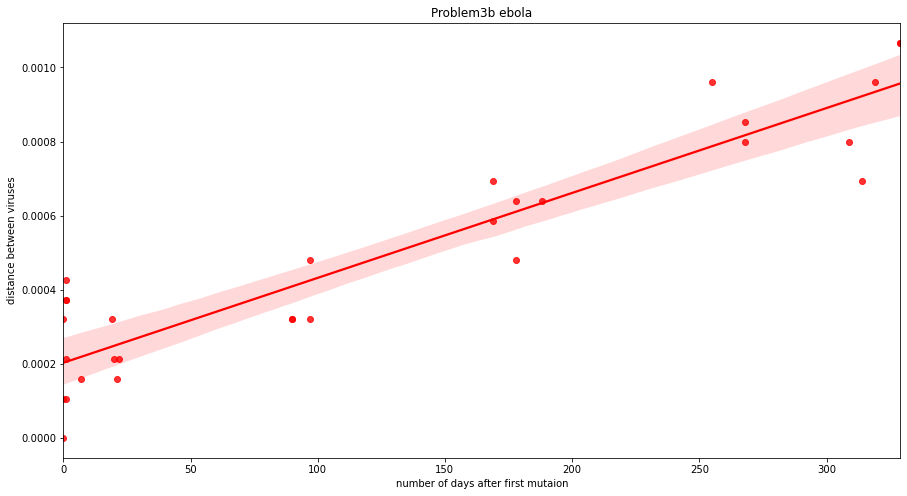

In [55]:
import seaborn as sns
import numpy as np;
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
#x=np.array(list_3_fin[2])
ax_ebola = sns.regplot(x=df_3_fin_ebola[3], y=df_3_fin_ebola[2], color="r")
ax_ebola.set( xlabel='number of days after first mutaion', ylabel='distance between viruses')
plt.title('Problem3b ebola')
plt.savefig('problem3b_ebola.png')

In [56]:
import scipy
from scipy.interpolate import *

pl=np.polyfit(df_3_fin_ebola[3],df_3_fin_ebola[2],1)
print(pl)


[2.29143194e-06 2.03132622e-04]


2.291431944873739e-06


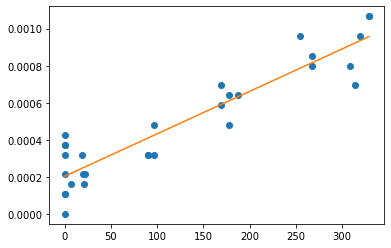

In [57]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df_3_fin_ebola[3],df_3_fin_ebola[2])
print(slope)
#this is just a trial
plt.plot(df_3_fin_ebola[3],df_3_fin_ebola[2],'o')
plt.plot(df_3_fin_ebola[3],np.polyval(pl,df_3_fin_ebola[3]),'-')

0.0 0.00020313262228725465
100 100
2.291431944873738e-06
2.291431944873738e-06


2.2914319448737382e-06

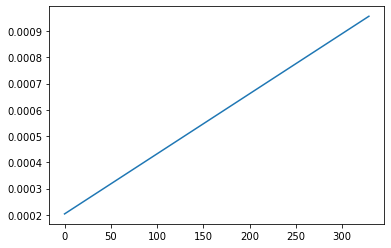

In [58]:
c=ax_ebola.get_lines()[0].get_xdata()
ct=ax_ebola.get_lines()[0].get_ydata()
print(c[0],ct[0])
plt.plot(c,ct)
print(len(c),len(ct))
print(float(ct[2]-ct[1])/float(c[2]-c[1]))
print(float(ct[3]-ct[1])/float(c[3]-c[1]))
(float(ct[99]-ct[0])/float(c[99]-c[0]))

In [59]:
hiv=SeqIO.parse("data/hiv.fa", "fasta")
dict_fasta_hiv={}
list_fasta_hiv=[]
for record in hiv:
    #print(record.id)
    dict_fasta_hiv[record.id]=record.seq
    list_fasta_hiv.append([record.id,record.seq])  

In [60]:
len(list_fasta_hiv)

63

In [61]:

#print(acc_vals)
list_fasta_ncbi_hiv=[]
dict_ncbi_fasta_hiv={}
d=0
for id_sec_fasta in list_fasta_hiv:
    record=load(id_sec_fasta[0])
    record.features
    temp_dict={}
    temp_dict["sequence"]=id_sec_fasta[1]
    #c=0
    for i in record.features:
        #print("new i")
        if(i.type == "source"):
            #print(i)
            temp_dict["host"]="Homo sapiens" #default than if exist setsthe other value
            
                
            try:
                #print(i.qualifiers["host"],id_sec_fasta[0])
                temp_dict["host"]=i.qualifiers["host"]
            except:
                print(id_sec_fasta[0],"no host",temp_dict["host"])    
            try:
                #print(i.qualifiers["collection_date"],id_sec_fasta[0])
                temp_dict["collection_date"]=i.qualifiers["collection_date"]
            except:
                print(id_sec_fasta[0],"no dateXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")    
            try:
               #print(i.qualifiers["country"],id_sec_fasta[0])
                temp_dict["country"]=i.qualifiers["country"]
            except:
                print(id_sec_fasta[0],"no countryxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
            #isolate
            #try:
                #print(i.qualifiers["isolate"],id_sec_fasta[0])
                #temp_dict["isolate"]=i.qualifiers["isolate"]
            #except:
                #print(id_sec_fasta[0],"no isolatexxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
            d+=1
            dict_ncbi_fasta_hiv[id_sec_fasta[0]]=temp_dict
            break
#print(d)
print(dict_ncbi_fasta_hiv)


AY901965.1 no host Homo sapiens
DQ164113.1 no host Homo sapiens
DQ011176.1 no host Homo sapiens
DQ396390.1 no host Homo sapiens
DQ369980.1 no host Homo sapiens
DQ369984.1 no host Homo sapiens
DQ396391.1 no host Homo sapiens
DQ396370.1 no host Homo sapiens
DQ351234.1 no host Homo sapiens
DQ396368.1 no host Homo sapiens
DQ396373.1 no host Homo sapiens
DQ093592.1 no host Homo sapiens
DQ011165.1 no host Homo sapiens
DQ164104.1 no host Homo sapiens
DQ396388.1 no host Homo sapiens
DQ351227.1 no host Homo sapiens
DQ445632.1 no host Homo sapiens
AY901975.1 no host Homo sapiens
DQ396369.1 no host Homo sapiens
DQ369988.1 no host Homo sapiens
DQ351224.1 no host Homo sapiens
AY901968.1 no host Homo sapiens
DQ351237.1 no host Homo sapiens
DQ351230.1 no host Homo sapiens
DQ396375.1 no host Homo sapiens
DQ369989.1 no host Homo sapiens
DQ351228.1 no host Homo sapiens
DQ369979.1 no host Homo sapiens
DQ164123.1 no host Homo sapiens
DQ396380.1 no host Homo sapiens
DQ396399.1 no host Homo sapiens
DQ056410

In [62]:
#["MN908947.3"]
dict_ncbi_fasta_date_hiv={}
list_ncbi_fasta_date_hiv=[]
for ii in dict_ncbi_fasta_hiv: 
    dict_ncbi_fasta_date_hiv[ii]={}
    dict_ncbi_fasta_date_hiv[ii]["collection_date"]=pd.to_datetime(dict_ncbi_fasta_hiv[ii]["collection_date"][0])
    dict_ncbi_fasta_date_hiv[ii]["sequence"]=dict_ncbi_fasta_hiv[ii]["sequence"]
    dict_ncbi_fasta_date_hiv[ii]["country"]=dict_ncbi_fasta_hiv[ii]["country"]
    list_ncbi_fasta_date_hiv.append([ii,pd.to_datetime(dict_ncbi_fasta_hiv[ii]["collection_date"][0]),dict_ncbi_fasta_hiv[ii]["sequence"],dict_ncbi_fasta_hiv[ii]["country"]])

In [63]:
list_ncbi_fasta_date_hiv.sort(key = lambda x: x[1]) 
list_ncbi_fasta_date_hd0_hiv=[]
ref_virus=list_ncbi_fasta_date_hiv[0]
for i in range(len(list_ncbi_fasta_date_hiv)):
    k=hamm_dist(list_ncbi_fasta_date_hiv[0][2],list_ncbi_fasta_date_hiv[i][2])
    #print(k)
    s=list_ncbi_fasta_date_hiv[i][1]-list_ncbi_fasta_date_hiv[0][1]
    s=str(s).replace(" 00:00:00","")
    #print(s)
    ss=[int(i) for i in s.split() if i.isdigit()]
    print(ss[0])
    list_ncbi_fasta_date_hd0_hiv.append([list_ncbi_fasta_date_hiv[i][0],s,k,ss])
print("ssssss",len(list_ncbi_fasta_date_hd0_hiv))

0
0
0
31
31
31
31
31
31
61
61
61
61
92
92
92
92
92
122
122
122
122
153
153
184
184
184
184
184
184
184
184
214
214
214
214
214
214
214
214
214
214
214
214
214
245
245
245
245
245
245
245
245
245
245
245
245
275
275
275
275
275
275
ssssss 63


In [64]:
#for i in range(len(list_ncbi_fasta_date_hd0_hiv)):
    #print(len(list_ncbi_fasta_date_hiv[i][2]))

In [65]:
#list_ncbi_fasta_date_hd0[2]/29745
list_3_fin_hiv=[]
for i in range(len(list_ncbi_fasta_date_hd0_hiv)):
    list_3_fin_hiv.append([list_ncbi_fasta_date_hd0_hiv[i][0],list_ncbi_fasta_date_hd0_hiv[i][1],jukes_cantor(float(list_ncbi_fasta_date_hd0_hiv[i][2]/10026)),list_ncbi_fasta_date_hd0_hiv[i][3][0]])
list_3_fin_hiv

[['DQ369979.1', '0 days', -0.0, 0],
 ['DQ445633.1', '0 days', 0.08682399296467794, 0],
 ['DQ164108.1', '0 days', 0.09244410169086972, 0],
 ['DQ369980.1', '31 days', 0.11233704440472433, 31],
 ['DQ369984.1', '31 days', 0.08850560801894533, 31],
 ['DQ351227.1', '31 days', 0.08358352308455265, 31],
 ['DQ396384.1', '31 days', 0.08604052773897829, 31],
 ['DQ369977.1', '31 days', 0.07416546462416422, 31],
 ['DQ396364.1', '31 days', 0.0968572103803548, 31],
 ['DQ396373.1', '61 days', 0.09255693454801046, 61],
 ['DQ369988.1', '61 days', 0.08985362006460525, 61],
 ['DQ369989.1', '61 days', 0.09097881718511268, 61],
 ['DQ445634.1', '61 days', 0.10817774852566198, 61],
 ['DQ396388.1', '92 days', 0.09549656294389221, 92],
 ['DQ396375.1', '92 days', 0.09154204941344543, 92],
 ['DQ351228.1', '92 days', 0.08648812193353853, 92],
 ['DQ396376.1', '92 days', 0.07935847299618964, 92],
 ['DQ396389.1', '92 days', 0.10392681802789483, 92],
 ['DQ093592.1', '122 days', 0.08682399296467794, 122],
 ['DQ093591.1

In [66]:
df_3_fin_hiv=pd.DataFrame(list_3_fin_hiv)

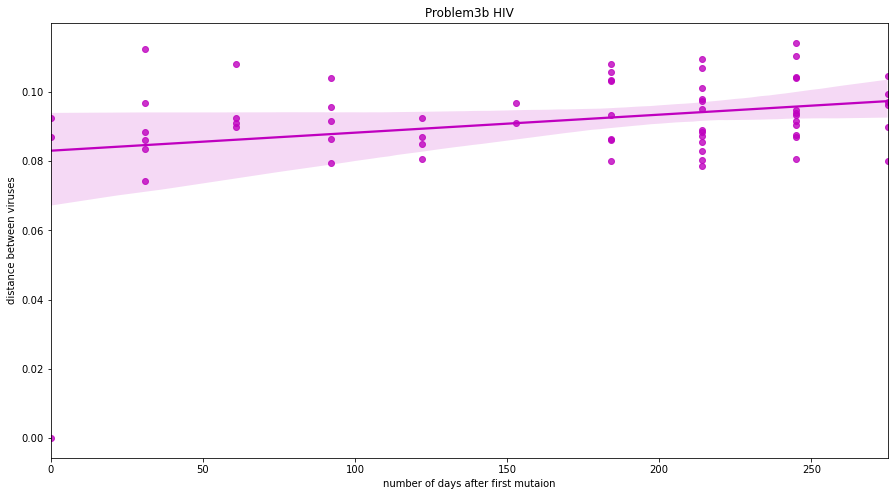

In [67]:
import seaborn as sns
import numpy as np;
from matplotlib import pyplot as plt
import seaborn as sns

fig=plt.figure(figsize=(15,8))
#x=np.array(list_3_fin[2])
ax_hiv = sns.regplot(x=df_3_fin_hiv[3], y=df_3_fin_hiv[2], color="m")
ax_hiv.set(xlabel='number of days after first mutaion',ylabel='distance between viruses')
plt.title('Problem3b HIV')
plt.savefig('problem3b_hiv.png')

0.0 0.08299450188785935
100 100
5.20561793853197e-05
5.205617938531971e-05


5.205617938531945e-05

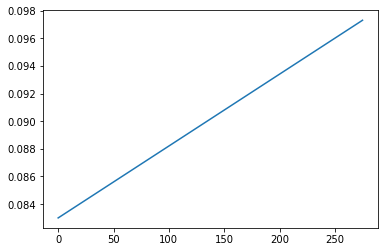

In [68]:
c=ax_hiv.get_lines()[0].get_xdata()
ct=ax_hiv.get_lines()[0].get_ydata()
print(c[0],ct[0])
plt.plot(c,ct)
print(len(c),len(ct))
print(float(ct[2]-ct[1])/float(c[2]-c[1]))
print(float(ct[3]-ct[1])/float(c[3]-c[1]))
(float(ct[99]-ct[0])/float(c[99]-c[0]))

In [69]:
import scipy
from scipy.interpolate import *

pl=np.polyfit(df_3_fin_hiv[3],df_3_fin_hiv[2],1)
print(pl)


[5.20561794e-05 8.29945019e-02]


5.2056179385319395e-05


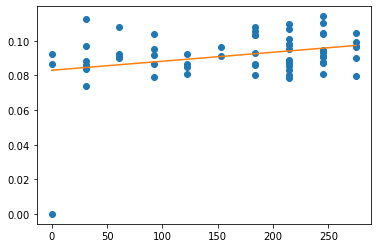

In [70]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df_3_fin_hiv[3],df_3_fin_hiv[2])
print(slope)
#this is just a trial
plt.plot(df_3_fin_hiv[3],df_3_fin_hiv[2],'o')
plt.plot(df_3_fin_hiv[3],np.polyval(pl,df_3_fin_hiv[3]),'-')

In [71]:
ebola_coeff = 2.2914319448737382e-06 
hiv_coeff = 5.205617938531945e-05
mutation_comments = """
ebola and sars cov2 seem to have similar trand in new multations ebola seems a little faster , we can claim that from the results of the graph and regression coeffiecients

however hiv seems to be mutating much faster than Sars Cov2 and ebola here is an article on that matter:
"Compared with HIV, SARS-CoV-2 is changing much more slowly as it spreads."
https://www.nature.com/articles/d41586-020-02544-6
"""

## Problem 4: Zoonotic transmission

There has recently been some talk of SARS-CoV-2 jumping to different animals, namely minks in the Netherlands. Let's see if this is true, and how the virus changed during the jump. These sequences are aligned to the SARS-CoV-2 sequences you worked with in the previous exercises. 

![](https://i.pinimg.com/originals/ac/d9/81/acd981a162499b120ebcaad5b5258981.jpg)

**TASK:** You are given eight SARS-CoV-2 sequences obtained from different animals in the accompanying _sars-cov-2-animals.fa_ fasta file. First, determine which animal species each sequence belongs to, and find out when they were sequenced (look at the collection date). You can find this in the NCBI metadata. Then, add these points to the plot you generated in Exercise 3a i.e. add the points to the plot and highlight them using a different color. Save the resulting figure into `problem4.png`. How do these viral sequences fit into the plot? Did the viruses have to drastically change to infect the animals or are the mutations expected? Write your observations into the `animal_comments` variable.
**[10 points]** 

In [72]:
animals=SeqIO.parse("data/sars-cov-2-animals.fa", "fasta")
dict_fasta_animals={}
list_fasta_animals=[]
for record in animals:
    print(record.id)
    dict_fasta_animals[record.id]=record.seq
    list_fasta_animals.append([record.id,record.seq])  

MT396266.1
MT457397.1
MT457398.1
MT457395.1
MT457396.1
MT747438.1
MT709104.1
MT709105.1


In [73]:

#print(acc_vals)
list_fasta_ncbi_animals=[]
dict_ncbi_fasta_animals={}
d=0
for id_sec_fasta in list_fasta_animals:
    record=load(id_sec_fasta[0])
    record.features
    temp_dict={}
    temp_dict["sequence"]=id_sec_fasta[1]
    #c=0
    for i in record.features:
        #print("new i")
        if(i.type == "source"):
            #print(i)
            temp_dict["host"]="UNKNOWN ANIMAL" #default than if exist setsthe other value
            
                
            try:
                #print(i.qualifiers["host"],id_sec_fasta[0])
                temp_dict["host"]=i.qualifiers["host"]
            except:
                print(id_sec_fasta[0],"no host",temp_dict["host"])    
            try:
                #print(i.qualifiers["collection_date"],id_sec_fasta[0])
                temp_dict["collection_date"]=i.qualifiers["collection_date"]
            except:
                print(id_sec_fasta[0],"no dateXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")    
            try:
               #print(i.qualifiers["country"],id_sec_fasta[0])
                temp_dict["country"]=i.qualifiers["country"]
            except:
                print(id_sec_fasta[0],"no countryxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
            #isolate
            #try:
                #print(i.qualifiers["isolate"],id_sec_fasta[0])
                #temp_dict["isolate"]=i.qualifiers["isolate"]
            #except:
                #print(id_sec_fasta[0],"no isolatexxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
            d+=1
            dict_ncbi_fasta_animals[id_sec_fasta[0]]=temp_dict
            break
#print(d)
print(dict_ncbi_fasta_animals)


{'MT396266.1': {'sequence': Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'), 'host': ['Mustela lutreola'], 'collection_date': ['2020-04-24'], 'country': ['Netherlands: Milheeze']}, 'MT457397.1': {'sequence': Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'), 'host': ['Mustela lutreola'], 'collection_date': ['2020-04-29'], 'country': ['Netherlands']}, 'MT457398.1': {'sequence': Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'), 'host': ['Mustela lutreola'], 'collection_date': ['2020-04-25'], 'country': ['Netherlands']}, 'MT457395.1': {'sequence': Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'), 'host': ['Mustela lutreola'], 'collection_date': ['2020-04-29'], 'country': ['Netherlands']}, 'MT457396.1': {'sequence': Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT'), 'host': ['Mustela lutreola'], 'collection_date': ['2020-04-29'], 'country': ['Netherlands']}, 'MT747438.1': {'sequence': Seq('GTCACTC

In [74]:
len(list_fasta_animals)

8

In [75]:
#["MN908947.3"]
dict_ncbi_fasta_date_animals={}
list_ncbi_fasta_date_animals=[]
for ii in dict_ncbi_fasta_animals: 
    dict_ncbi_fasta_date_animals[ii]={}
    dict_ncbi_fasta_date_animals[ii]["collection_date"]=pd.to_datetime(dict_ncbi_fasta_animals[ii]["collection_date"][0])
    dict_ncbi_fasta_date_animals[ii]["sequence"]=dict_ncbi_fasta_animals[ii]["sequence"]
    dict_ncbi_fasta_date_animals[ii]["country"]=dict_ncbi_fasta_animals[ii]["country"]
    list_ncbi_fasta_date_animals.append([ii,pd.to_datetime(dict_ncbi_fasta_animals[ii]["collection_date"][0]),dict_ncbi_fasta_animals[ii]["sequence"],dict_ncbi_fasta_animals[ii]["country"]])

In [76]:
list_ncbi_fasta_date_animals.sort(key = lambda x: x[1]) 
list_ncbi_fasta_date_hd0_animals=[]
ref_virus=list_ncbi_fasta_date_animals[0]
for i in range(len(list_ncbi_fasta_date_animals)):
    k=hamm_dist(list_ncbi_fasta_date[0][2],list_ncbi_fasta_date_animals[i][2])
    #print(k)
    s=list_ncbi_fasta_date_animals[i][1]-list_ncbi_fasta_date[0][1]
    s=str(s).replace(" 00:00:00","")
    #print(s)
    ss=[int(i) for i in s.split() if i.isdigit()]
    print(ss[0])
    list_ncbi_fasta_date_hd0_animals.append([list_ncbi_fasta_date_animals[i][0],s,k,ss])
print("ssssss",len(list_ncbi_fasta_date_hd0_animals))

101
145
146
150
150
150
165
165
ssssss 8


In [77]:
for i in range(len(list_ncbi_fasta_date_hd0_animals)):
    print(len(list_ncbi_fasta_date_animals[i][2]))

29745
29745
29745
29745
29745
29745
29745
29745


In [78]:
#list_ncbi_fasta_date_hd0[2]/29745
list_3_fin_animals=[]
for i in range(len(list_ncbi_fasta_date_hd0_animals)):
    list_3_fin_animals.append([list_ncbi_fasta_date_hd0_animals[i][0],list_ncbi_fasta_date_hd0_animals[i][1],jukes_cantor(float(list_ncbi_fasta_date_hd0_animals[i][2]/29745)),list_ncbi_fasta_date_hd0_animals[i][3][0]])
list_3_fin_animals

[['MT747438.1', '101 days', 0.00016811431843997965, 101],
 ['MT396266.1', '145 days', 0.0002690010004290835, 145],
 ['MT457398.1', '146 days', 0.0005044560472675743, 146],
 ['MT457397.1', '150 days', 0.0002690010004290835, 150],
 ['MT457395.1', '150 days', 0.0004035376900662144, 150],
 ['MT457396.1', '150 days', 0.0002690010004290835, 150],
 ['MT709104.1', '165 days', 0.0003699012550741617, 165],
 ['MT709105.1', '165 days', 0.0003699012550741617, 165]]

In [79]:
df_3_fin_animals=pd.DataFrame(list_3_fin_animals)

In [80]:
df_3_fin_animals

,0,1,2,3
0,MT747438.1,101 days,0.000168,101
1,MT396266.1,145 days,0.000269,145
2,MT457398.1,146 days,0.000504,146
3,MT457397.1,150 days,0.000269,150
4,MT457395.1,150 days,0.000404,150
5,MT457396.1,150 days,0.000269,150
6,MT709104.1,165 days,0.000370,165
7,MT709105.1,165 days,0.000370,165


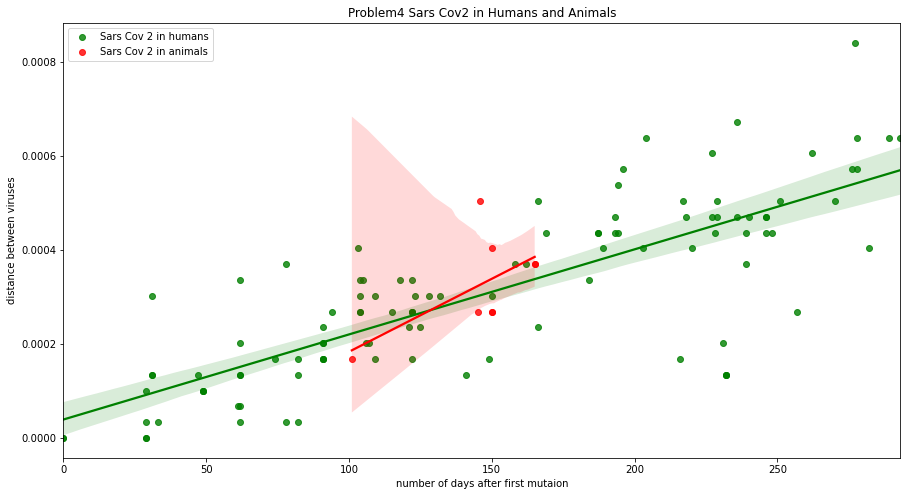

In [81]:
import seaborn as sns
import numpy as np;
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
#x=np.array(list_3_fin[2])
ax = sns.regplot(x=df_3_fin[3], y=df_3_fin[2], color="g",label="Sars Cov 2 in humans")
ax1 = sns.regplot(x=df_3_fin_animals[3], y=df_3_fin_animals[2], color="r",label="Sars Cov 2 in animals")
ax.set(xlabel='number of days after first mutaion', ylabel='distance between viruses')
ax.legend()
ax1.legend()
plt.title('Problem4 Sars Cov2 in Humans and Animals')
plt.savefig('problem4.png')

#plt.savefig('problem3a.png')

In [82]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df_3_fin_animals[3],df_3_fin_animals[2])
print(slope)
#this is just a trial

3.105513365312395e-06


In [83]:
the_slope_animals=3.105513365312395e-06

In [84]:
animal_comments = """
the calculation for regression coeficient for animals: 3.105513365312395e-06 which is higher than  1.8105030746624837e-06
so it seems like it is mutated more in those animals but just 8 mutations is not enough data in my opinion so that we can surelly confirm or say that it mutates faster in animals
also the virus could be mutated before it jumped into the animal or it just mutates faster in animals, i say this having this little data...

"""

## Bonus problem: Single Nucleotide Polymorphisms

Are all mutations equally possible? Probably not. After all, if we get an unfortunate mutation on our spike protein that flips a key amino-acid, it might well happen that our virus won't be able to bind and enter host cells anymore. Such a mutation would clearly be devastating for the virus and natural selection would quickly eliminate all viruses with this mutation. However, other mutations are probably less devastating and entirely possible. There are only 21 amino acids, and several codons can code for the same amino acid, so a change in nucleotide sequence might not even affect the protein sequence. Therefore, we might expect these mutations to be more common than potentially destructive mutations. And, as you saw in lectures, some proteins belong to the same general family e.g. hydrophylic/hydrophobic, charged, ... and a switch in amino acid with another with the same general properties might not be that bad. Let's take a look.

**TASK:**

For every single nucleotide location on the SARS-CoV-2 aligned sequences, find the distribution of nucleotides across all sequences and calculate its [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)). Plot a bar chart where the nucleotide location is on the x-axis, and the entropy on the y-axis. Since you will be plotting almost 30k bars, increase their width so they actually show up. Save the resulting figure into `problem-snp.png`.

Next, using your ORF finder form HW1, find the longest ORF on each aligned sequence -- this should correspond to ORF1ab at the beginning of the sequence with length 13,218 -- and determine which proteins were changed due to mutations. When translating your ORFs to protein sequences, skip over indels e.g. AT-GC should be treated as ATGC. In case proteins were changed due to mutation look at the table of amino-acids and their properties. Which mutations are most common, and do they make sense? If an amino-acid is changed, does it belong to the same group as the others? You can use the refernece SARS-CoV-2 genome as the reference (NC_045512). Write your observations into the `snp_comments` variable. List at least two interesting mutations, either at the nucleotide level or at the amino-acid level. How many times does the mutation occur? Why are they interesting?

**[10 points]**

Your ORF finder only needs to be able to find ORFs on the + strand, so even if you haven't implement your ORF finder entirely correctly, it should not be an issue. In case your ORF finder does not find ORFs on the + strand correctly, please reach out and we'll get it sorted.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Amino_Acids.svg/700px-Amino_Acids.svg.png)

In [85]:
snp_comments = """
List at least two interesting mutations. How many times do they occur? Why are they interesting?
"""

## Bonus problem: Pretty dendrograms

Flame wars are fought every day online as people argue between which programming language is better. These battles are never won or lost, as each side stubbornly sticks to their guns, not budging a single inch from their respective standpoints. Every few years, new contenders enter the fray and the world is ever more divided. In bioinformatics, it usually comes down to Python versus R (despite what Julia fans like to say, the Julia ecosystem is nowhere near complete enough to even begin to compete). Although we are, at this subject, clearly biased towards Python (we are making you complete these homeworks in Python after all), we still concede that R is better than Python at data visualization, particularly at drawing dendrograms.

**TASK:**

This bonus assignment is completely open-ended. We have by now drawn at least two dendrograms using scipy: in HW2 and in this homework in Problem 2. However, these dendrograms are not the most visually appealing. They are quick and dirty and get the job done. Your task is to implement prettier dendrogram drawing using Python's matplotlib. This can include one of the following:
- radial layout ([example 1](https://www.instituteofcaninebiology.org/uploads/1/9/6/9/19691109/2336926.png?797), [example 2](https://leilabattison.files.wordpress.com/2012/02/dn14392-1_1891.jpg))
- date-based layout ([example 1](https://nextstrain.org/ncov/global)). The dendrogram is constructed in the same way as before - using genetic distances, but notice how the branch lengths are now determined by date instead of length.

Make use of colors to highlight different dates, countries or regions. You have full creative freedom here.

Save your dendrogram into `problem-pretty-dendrogram.png`. Since this problem may require a fair bit of code, put your implementation in a new file named `pretty_dendrogram.py`. If it is apparent from your dendrogram that you put effort into the visualization and if it looks visually appealing, you'll automatically get full points. Visually appealing may seem subjective, but the examples above should serve as a guideline to what is "very visually appealing".

**[10 points]**